In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import arviz as az
import cvxpy as cp
import pymc as pm
import pytensor.tensor as at
import stan

In [2]:
import sys
sys.path.append('../utils')

In [3]:
import nest_asyncio
nest_asyncio.apply()

#### Exercise 1

Given the posterior density
$$\pi(\theta|5) = 56 \theta^6 (1 - \theta),$$
the MAP estimator is obtained by setting the first derivative to 0:
$$\pi'(\theta|5) = 56 \cdot 6 \theta^5 (1 - \theta) - 56 \theta^6 = 56 \theta^5 (6 - 7 \theta) = 0,$$
which yields $\theta = 6/7$.

#### Exercise 2

For i.i.d. $Y_i \sim N(\mu, \sigma)$ we have
$$f(Y_i) 
= \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac12 \left(\frac{Y_i - \mu}{\sigma}\right)^2\right) 
= \sqrt{\frac{\tau}{2\pi}} \exp\left(-\frac{\tau}{2} (Y_i - \mu)^2\right),$$
where $\tau = \sigma^{-2}$.

Then the likelihood
$$f(Y_1, ..., Y_n|\tau) 
= \prod_{i=1}^n f(Y_i)
= \left(\frac{\tau}{2\pi}\right)^{\frac{n}{2}} \exp\left(-\frac{\tau}{2}\sum_{i=1}^n (Y_i - \mu)^2\right)
= \left(\frac{\tau}{2\pi}\right)^{\frac{n}{2}} \exp\left(-\frac12 \tau n s^2\right),$$
where $s^2 = n^{-1}\sum_{i=1}^n (Y_i - \mu)^2$.

#### Exercise 3

Given $\mathbf{Y}$, $\{\bar{Y} - E[\mu|\mathbf{Y}]\}$ is a constant, and so it is conditionally uncorrelated with $\{E[\mu|\mathbf{Y}] - \mu\}$.

#### Exercise 4

In [4]:
data = pd.read_csv('../data/Stock_Bond.csv', parse_dates=[0], index_col=0, date_format='%d-%b-%y')
data.head()

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,XOM_Volume,XOM_AC,S&P_AC,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,3611200,4.52,246.45,91880000,5.86,6.48,7.18,7.44,8.49,9.97
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,9040000,4.63,252.19,181900000,5.85,6.41,7.08,7.35,8.44,9.90
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,7931200,4.62,252.78,189300000,5.85,6.42,7.08,7.36,8.41,9.86
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,5351200,4.61,255.33,190900000,5.78,6.37,7.05,7.33,8.40,9.82
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,9680000,4.61,257.28,194500000,5.78,6.36,7.04,7.31,8.37,9.76


In [5]:
y = data.iloc[:, [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 20]]
n = y.shape[0]
m = y.shape[1] - 1
r = y.pct_change().dropna()

In [6]:
block_size = 250

In [7]:
n_blocks = (y.shape[0] - 1) // block_size + 1
blocks = [r.iloc[i * block_size:(i + 1) * block_size] for i in range(n_blocks)]

In [8]:
r_train = blocks[0].iloc[:, :m]
mkt_train = blocks[0].iloc[:, m]
r_test = blocks[1].iloc[:, :m]

In [9]:
def find_optimal_weights(mu, Sigma, gamma_val):
    n = len(mu)
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Maximize(ret - gamma / 2 * risk), [cp.sum(w) == 1])
    
    gamma.value = gamma_val
    prob.solve()
    return w.value

In [10]:
def calculate_capm_weights(r_train, mkt_train, lam=3):
    # define the model
    with pm.Model(coords={'predictors': r_train.columns.values}) as model:
        # Priors for unknown model parameters
        meanbeta = pm.Normal('meanbeta', 1, 1000)
        taubeta = pm.Uniform('taubeta', 1, 100)
        beta = pm.Normal('beta', meanbeta, tau=taubeta, shape=(1, m))
        tau = pm.Gamma('tau', 0.1, 0.001, shape=(1, m))
        # Likelihood for the observed data
        R_ = pm.Normal('R', mu=beta * mkt_train.values.reshape(-1, 1), tau=tau, observed=r_train)

    # sample from the model
    with model:
        idata = pm.sample(chains=4)

    # extract the estimates of beta and sigma
    summ = az.summary(idata, hdi_prob=0.95)
    sigma_eps = 1 / np.sqrt(summ.iloc[12:, 0])
    beta = summ.iloc[1:11, 0]

    # calculate mean-var inputs
    mu_Capm = beta * mkt_train.mean()
    Omega_Capm = pd.DataFrame(
        beta.values.reshape(-1, 1) @ beta.values.reshape(1, -1) * mkt_train.var() + np.diag(sigma_eps ** 2),
        index=r_train.columns, columns=r_train.columns
    )
    
    # find CAPM-based weights
    return find_optimal_weights(mu_Capm.values, Omega_Capm.values, lam)

In [11]:
def calculate_model_free_weights(r_train, mkt_train, lam=3):
    mu_model_free = r_train.mean()
    Omega_model_free = r_train.cov()
    return find_optimal_weights(mu_model_free.values, Omega_model_free.values, lam)

In [12]:
def evaluate(r, block_size, weight_func):
    n_blocks = (y.shape[0] - 1) // block_size + 1
    blocks = [r.iloc[i * block_size:(i + 1) * block_size] for i in range(n_blocks)]
    
    r_p = np.zeros(n_blocks)
    sigma_p = np.zeros(n_blocks)
    
    for i in range(n_blocks - 1):
        print(f'Training on block {i}, testing on block {i+1}')
        r_train = blocks[i].iloc[:, :m]
        mkt_train = blocks[i].iloc[:, m]
        r_test = blocks[i + 1].iloc[:, :m]
        weights = weight_func(r_train, mkt_train)
        ret = (weights * r_test).sum(axis=1)
        r_p[i] = ret.mean()
        sigma_p[i] = ret.std()
    
    return r_p, sigma_p    

In [13]:
r_p_mf, sigma_p_mf = evaluate(r, block_size, calculate_model_free_weights)

Training on block 0, testing on block 1
Training on block 1, testing on block 2
Training on block 2, testing on block 3
Training on block 3, testing on block 4
Training on block 4, testing on block 5
Training on block 5, testing on block 6
Training on block 6, testing on block 7
Training on block 7, testing on block 8
Training on block 8, testing on block 9
Training on block 9, testing on block 10
Training on block 10, testing on block 11
Training on block 11, testing on block 12
Training on block 12, testing on block 13
Training on block 13, testing on block 14
Training on block 14, testing on block 15
Training on block 15, testing on block 16
Training on block 16, testing on block 17
Training on block 17, testing on block 18
Training on block 18, testing on block 19


In [14]:
r_p_capm, sigma_p_capm = evaluate(r, block_size, calculate_capm_weights)

Training on block 0, testing on block 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Training on block 1, testing on block 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


Training on block 2, testing on block 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


Training on block 3, testing on block 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


Training on block 4, testing on block 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


Training on block 5, testing on block 6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Training on block 6, testing on block 7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Training on block 7, testing on block 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Training on block 8, testing on block 9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Training on block 9, testing on block 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Training on block 10, testing on block 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Training on block 11, testing on block 12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Training on block 12, testing on block 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Training on block 13, testing on block 14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Training on block 14, testing on block 15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Training on block 15, testing on block 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


Training on block 16, testing on block 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Training on block 17, testing on block 18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Training on block 18, testing on block 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


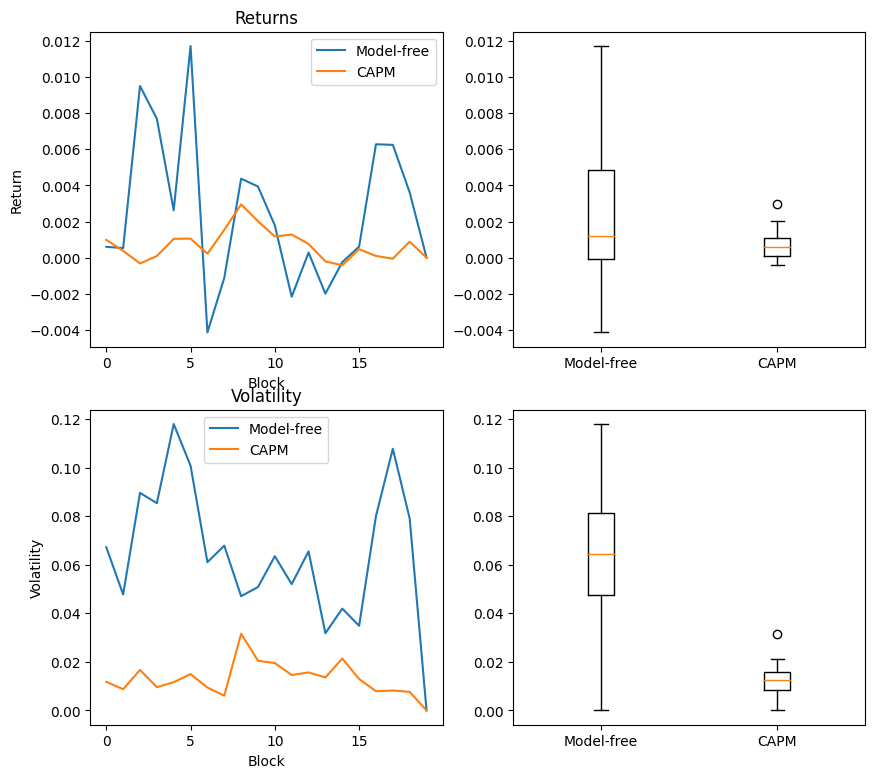

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))

axs[0][0].plot(r_p_mf, label='Model-free');
axs[0][0].plot(r_p_capm, label='CAPM');
axs[0][0].set_title('Returns');
axs[0][0].set_xlabel('Block');
axs[0][0].set_ylabel('Return');
axs[0][0].legend();

axs[0][1].boxplot([r_p_mf, r_p_capm], labels=['Model-free', 'CAPM']);

axs[1][0].plot(sigma_p_mf, label='Model-free');
axs[1][0].plot(sigma_p_capm, label='CAPM');
axs[1][0].set_title('Volatility');
axs[1][0].set_xlabel('Block');
axs[1][0].set_ylabel('Volatility');
axs[1][0].legend();

axs[1][1].boxplot([sigma_p_mf, sigma_p_capm], labels=['Model-free', 'CAPM']);

We can see that using CAPM-based estimates results in lower return and volatility, but a higher Sharpe ratio:

In [16]:
pd.DataFrame({
    'Model-free': [np.mean(r_p_mf), np.mean(sigma_p_mf), np.mean(r_p_mf) / np.mean(sigma_p_mf)],
    'CAPM': [np.mean(r_p_capm), np.mean(sigma_p_capm), np.mean(r_p_capm) / np.mean(sigma_p_capm)],
}, index=['Return', 'Volatility', 'Sharpe ratio'])

,Model-free,CAPM
Return,0.002506,0.000697
Volatility,0.064575,0.013102
Sharpe ratio,0.038815,0.053194


#### Exercise 5

In [17]:
gm = r['GM_AC']
mkt = r['S&P_AC']

In [18]:
model_ma = """
data {
  int<lower=0> T;
  vector[T] r;
  vector[T] rM;
}
parameters {
  real<lower=0> tau;
  real beta;
  real<lower=-1, upper=1> theta;
}
transformed parameters {
  real<lower=0> sigma = 1 / sqrt(tau);
  vector[T] w;
  w[1] = r[1] - beta * rM[1];
  for (t in 2:T) {
    w[t] = r[t] - (beta * rM[t] + theta * w[t-1]);
  }
}
model {
  beta ~ normal(1, 0.5);
  theta ~ normal(0, 100);
  tau ~ gamma(0.01, 0.0001);
  r[1] ~ normal(beta * rM[1], sigma);
  for (t in 2:T) {
    r[t] ~ normal(beta * rM[t] + theta * w[t-1], sigma);
  }
}
"""

In [19]:
data = {
    'r': gm.values,
    'T': gm.shape[0],
    'rM': mkt.values,
}

In [20]:
posterior_ma = stan.build(model_ma, data=data);
fit_ma = posterior_ma.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_lhuelt1a/model_bvpcfq5a.stan', line 23, column 20: Argument
    0.0001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_lhuelt1a/model_bvpcfq5a.stan', line 23, column 14: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_lhuelt1a/model_bvpcfq5a.stan', line 22, column 20: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9

In [21]:
idata = az.from_pystan(fit_ma)

In [22]:
var_names = ['beta', 'theta', 'sigma']

In [23]:
az.summary(idata, var_names=var_names, round_to=6, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.031648,0.022820,0.988259,1.078327,0.000352,0.000249,4182.565352,2732.890974,1.000159
theta,-0.030919,0.014674,-0.058556,-0.002511,0.000223,0.000162,4324.960731,3387.553837,1.000151
sigma,0.017413,0.000180,0.017081,0.017773,0.000003,0.000002,4379.515828,2958.068417,0.999988


/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


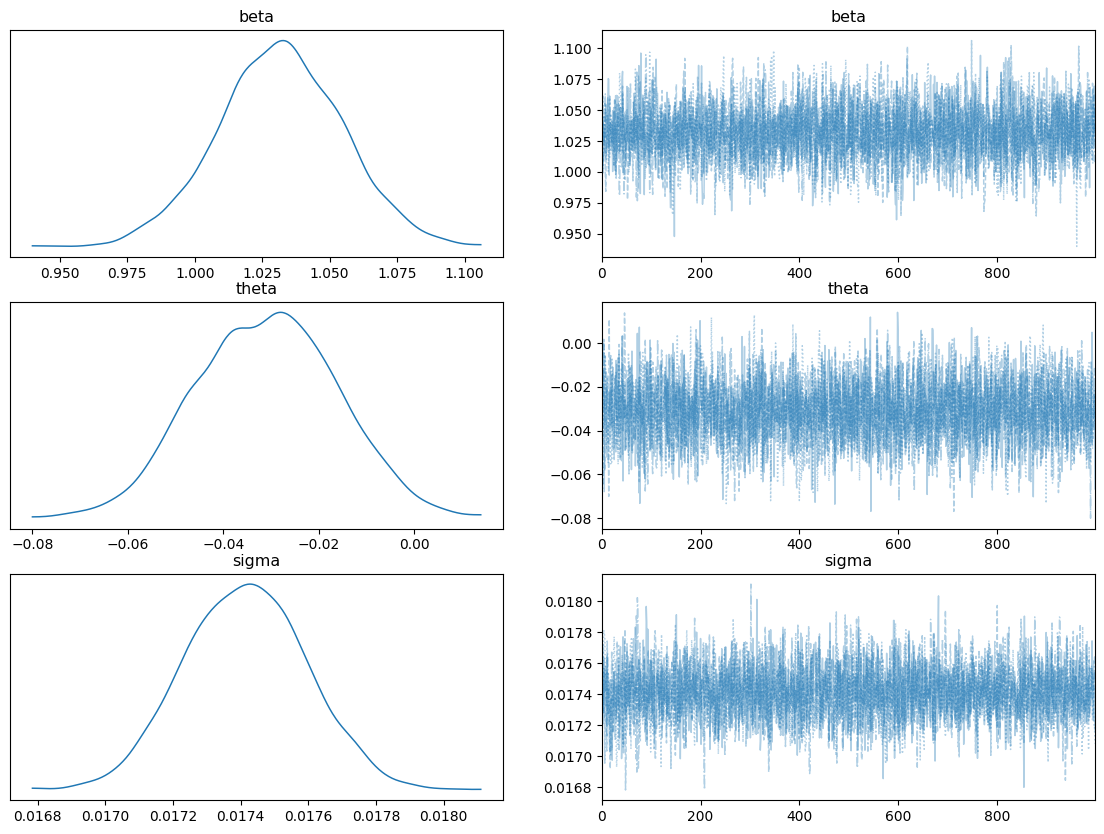

In [24]:
az.plot_trace(idata, var_names=var_names, combined=True, figsize=(14, 10));

#### Exercise 6

In [25]:
model_garch = """
data {
  int<lower=0> T;
  vector[T] r;
  vector[T] rM;
}
parameters {
  // CAPM beta
  real beta;

  // MA(1) in the returns
  real<lower=-1, upper=1> theta;

  // GARCH(1,1) parameters
  real<lower=0> sigma1;
  real<lower=0> alpha0;
  real<lower=0, upper=1> alpha1;
  real<lower=0, upper=(1-alpha1)> beta1;
}
transformed parameters {
  // return innovations
  vector[T] w;
  w[1] = r[1] - beta * rM[1];
  for (t in 2:T) {
    w[t] = r[t] - (beta * rM[t] + theta * w[t-1]);
  }

  // volatility of return innovations
  array[T] real<lower=0> sigma;
  sigma[1] = sigma1;
  for (t in 2:T) {
    sigma[t] = sqrt(alpha0 + alpha1 * square(w[t-1]) + beta1 * square(sigma[t-1]));
  }
}
model {
  beta ~ normal(1, 0.5);
  theta ~ normal(0, 100);

  sigma1 ~ uniform(0, 0.5);
  alpha0 ~ uniform(0, 0.2);
  alpha1 ~ uniform(0.00001, 1.0);
  beta1 ~ uniform(0.00001, 1.0);
  
  r[1] ~ normal(beta * rM[1], sigma[1]);
  for (t in 2:T) {
    r[t] ~ normal(beta * rM[t] + theta * w[t-1], sigma[t]);
  }
}
"""

In [26]:
posterior_garch = stan.build(model_garch, data=data);
fit_garch = posterior_garch.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_7mte70_a/model_eg53tpf2.stan', line 42, column 18: Argument
    0.00001 suggests there may be parameters that are not unit scale;
    consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_7mte70_a/model_eg53tpf2.stan', line 42, column 2: Parameter
    beta1 is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_7mte70_a/model_eg53tpf2.stan', 

In [27]:
idata = az.from_pystan(fit_garch)

In [28]:
var_names = ['beta', 'theta', 'alpha0', 'alpha1', 'beta1']

In [29]:
az.summary(idata, var_names=var_names, round_to=6, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.022941,0.024494,0.976744,1.073156,0.000397,0.000281,3812.454651,2629.106937,0.999731
theta,-0.016471,0.015904,-0.047269,0.014955,0.000248,0.000205,4127.759034,2671.100140,1.000389
alpha0,0.000005,0.000001,0.000003,0.000007,0.000000,0.000000,1706.046618,2064.133235,1.001154
alpha1,0.048472,0.006705,0.035687,0.062295,0.000140,0.000099,2272.124145,2477.603449,1.001053
beta1,0.935373,0.009064,0.917206,0.952959,0.000215,0.000152,1773.427438,2019.955967,1.001588


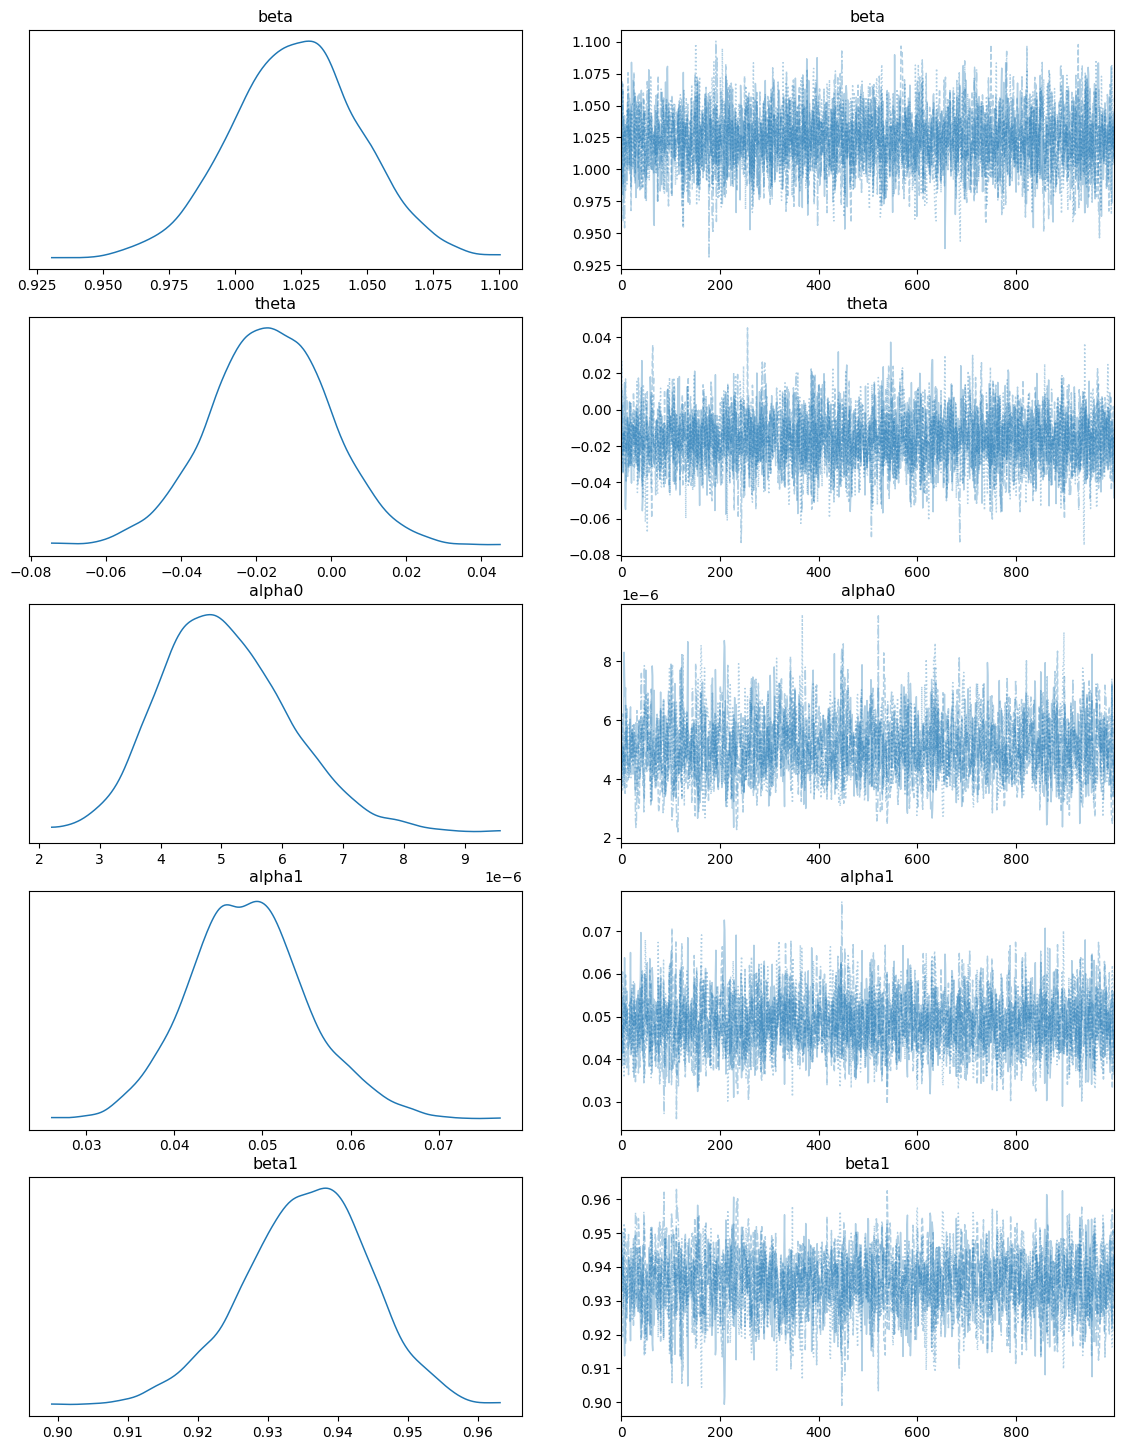

In [30]:
az.plot_trace(idata, var_names=var_names, combined=True, figsize=(14, 18));

#### Exercise 7

In [31]:
data = pd.read_csv('../data/Stock_Bond.csv', parse_dates=[0], index_col=0, date_format='%d-%b-%y')
data.head()

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,XOM_Volume,XOM_AC,S&P_AC,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,3611200,4.52,246.45,91880000,5.86,6.48,7.18,7.44,8.49,9.97
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,9040000,4.63,252.19,181900000,5.85,6.41,7.08,7.35,8.44,9.90
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,7931200,4.62,252.78,189300000,5.85,6.42,7.08,7.36,8.41,9.86
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,5351200,4.61,255.33,190900000,5.78,6.37,7.05,7.33,8.40,9.82
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,9680000,4.61,257.28,194500000,5.78,6.36,7.04,7.31,8.37,9.76


In [32]:
y = data.iloc[:, [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 20]]
n = y.shape[0]
m = y.shape[1] - 1
r = y.pct_change().dropna()

In [33]:
block_size = 250

In [35]:
def utility(x, lam):
    """Utility function from Eq. (16.17)"""
    return 1 - np.exp(-lam * x)

In [36]:
def calculate_resample_weights(r_train, mkt_train, lam=3, x0=1):
    # define the model
    with pm.Model(coords={'predictors': r_train.columns.values}) as model:
        # Priors for unknown model parameters
        meanbeta = pm.Normal('meanbeta', 1, 1000)
        taubeta = pm.Uniform('taubeta', 1, 100)
        beta = pm.Normal('beta', meanbeta, tau=taubeta, shape=(1, m))
        tau = pm.Gamma('tau', 0.1, 0.001, shape=(1, m))
        sigma = pm.Deterministic('sigma', 1 / at.sqrt(tau))
        # Likelihood for the observed data
        R_ = pm.Normal('R', mu=beta * mkt_train.values.reshape(-1, 1), tau=tau, observed=r_train)

    # sample from the model
    with model:
        idata = pm.sample(chains=4)

    # extract the estimates of beta and sigma
    summ = az.summary(idata, hdi_prob=0.95)
    sigma_eps = 1 / np.sqrt(summ.iloc[12:22, 0])
    beta = summ.iloc[1:11, 0]

    # calculate mean-var inputs
    mu_Capm = beta * mkt_train.mean()
    Omega_Capm = pd.DataFrame(
        beta.values.reshape(-1, 1) @ beta.values.reshape(1, -1) * mkt_train.var() + np.diag(sigma_eps ** 2),
        index=r_train.columns, columns=r_train.columns
    )
    
    # find CAPM-based weights
    w0 = find_optimal_weights(mu_Capm.values, Omega_Capm.values, 3)
        
    # sample returns
    n_chain = idata.posterior.dims['chain']
    n_draw = idata.posterior.dims['draw']
    n_var = r_train.shape[1]
    ret = np.zeros((n_chain * n_draw, n_var))
    for i_chain in range(n_chain):
        for i_draw in range(n_draw):
            betas = idata.posterior['beta'][i_chain, i_draw]
            sigma_eps = idata.posterior['sigma'][i_chain, i_draw]
            mus = np.squeeze(betas * mkt_train.mean())
            Sigma = betas.values.reshape(-1, 1) @ betas.values.reshape(1, -1) * mkt_train.var() + np.diag(np.squeeze(sigma_eps) ** 2)
            ret[i_chain * n_draw + i_draw, :] = stats.multivariate_normal.rvs(size=1, mean=mus, cov=Sigma)
    
    def obj_func(w):
        # objective function is for minimization, hence negate the value
        return -np.mean(utility(x0 * (1 + ret @ w.reshape(-1, 1)), lam))
    
    res = minimize(obj_func, w0)
    if res.success:
        return res.x
    else:
        raise ValueError('Unable to find the optimal weight')

In [37]:
r_p_est, sigma_p_est = evaluate(r, block_size, calculate_resample_weights)

Training on block 0, testing on block 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Training on block 1, testing on block 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Training on block 2, testing on block 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 3, testing on block 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 4, testing on block 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 5, testing on block 6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Training on block 6, testing on block 7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Training on block 7, testing on block 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Training on block 8, testing on block 9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 9, testing on block 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Training on block 10, testing on block 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 11, testing on block 12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 12, testing on block 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 13, testing on block 14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Training on block 14, testing on block 15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Training on block 15, testing on block 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Training on block 16, testing on block 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Training on block 17, testing on block 18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Training on block 18, testing on block 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


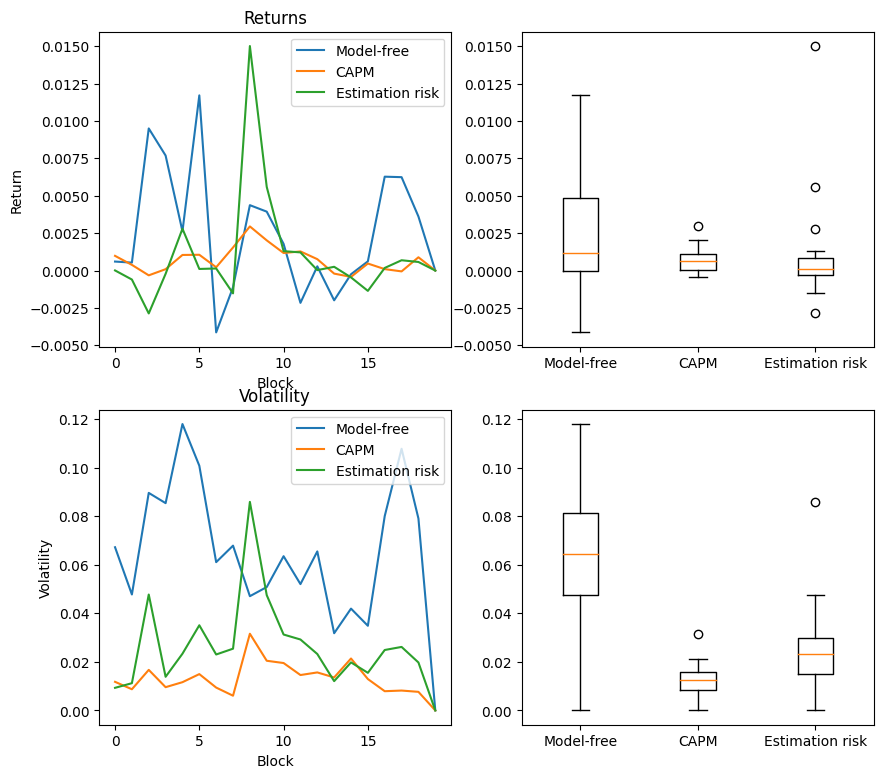

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))

axs[0][0].plot(r_p_mf, label='Model-free');
axs[0][0].plot(r_p_capm, label='CAPM');
axs[0][0].plot(r_p_est, label='Estimation risk');
axs[0][0].set_title('Returns');
axs[0][0].set_xlabel('Block');
axs[0][0].set_ylabel('Return');
axs[0][0].legend();

axs[0][1].boxplot([r_p_mf, r_p_capm, r_p_est], labels=['Model-free', 'CAPM', 'Estimation risk']);

axs[1][0].plot(sigma_p_mf, label='Model-free');
axs[1][0].plot(sigma_p_capm, label='CAPM');
axs[1][0].plot(sigma_p_est, label='Estimation risk');
axs[1][0].set_title('Volatility');
axs[1][0].set_xlabel('Block');
axs[1][0].set_ylabel('Volatility');
axs[1][0].legend();

axs[1][1].boxplot([sigma_p_mf, sigma_p_capm, sigma_p_est], labels=['Model-free', 'CAPM', 'Estimation risk']);

We can see that taking into account the estimation risk provides a slight improvement to the Sharpe ratio:

In [39]:
pd.DataFrame({
    'Model-free': [np.mean(r_p_mf), np.mean(sigma_p_mf), np.mean(r_p_mf) / np.mean(sigma_p_mf)],
    'CAPM': [np.mean(r_p_capm), np.mean(sigma_p_capm), np.mean(r_p_capm) / np.mean(sigma_p_capm)],
    'Estimation risk': [np.mean(r_p_est), np.mean(sigma_p_est), np.mean(r_p_est) / np.mean(sigma_p_est)],
}, index=['Return', 'Volatility', 'Sharpe ratio'])

,Model-free,CAPM,Estimation risk
Return,0.002506,0.000697,0.001042
Volatility,0.064575,0.013102,0.026196
Sharpe ratio,0.038815,0.053194,0.039788
